# First Steps in Liesel

## Import Packages

In [44]:
from jax.random import key, split  # pseudo-random number functions
import jax.numpy as jnp            # jax-compatible numpy (numerical python)
import numpy as np
import pandas as pd                # data-frames
import plotnine as p9              # plotting like ggplot2 in R

# tensorflow probability for distributions and bijectors
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb


import liesel.model as lsl          # liesel model building functionality
import liesel.goose as gs           # liesel MCMC sampling functionality


## Generate example data

We generate a simple linear location-scale regression model. Imagine you are 
modeling the weight (in kg) of pets ($y$), and you know that in your sample, you have
dogs ($x = 1$) and cats ($x = 0$). Both the average weight and the variability of the 
weight is wildly different for cats and dogs. This can be captured in a statistical 
model. For simplicity, we assume that the weight itself follows a Gaussian distribution:
$$
y_i \sim N(\mu_i, \sigma^2_i),
$$
with 
$$
\begin{aligned}
\mu_i  & = \beta_0 + \beta_1x_i \\
\log(\sigma_i) & = \gamma_0 + \gamma_1x_i,
\end{aligned}
$$
where $i = 1, \dots, N$ is the sample indicator. We generate the data using

$$
\begin{aligned}
\beta_0 = 5, &\quad & \beta_1 = 15,\\
\gamma_0 = 0, & \quad &\gamma_1 = 6,
\end{aligned}
$$
which implies that we assume a weight distribution of $N(5, 1)$ for cats and
$N(20, 6^2)$ for dogs.

In [45]:
k = key(42)        # starting pseudo-random number generation seed
k, k0, k1 = split(k, 3)   # generate sub-seeds

nobs = 300

b0 = 5.0
b1 = 15.0

g0 = jnp.log(1.0)
g1 = jnp.log(6.0)

x = tfd.Bernoulli(probs=0.5).sample((nobs,), k0)
eps = tfd.Normal(loc=0.0, scale=1.0).sample((nobs,), k1)

loc = b0 + b1 * x
scale = jnp.exp(g0 + g1 * x)
y = loc + scale * eps

df = pd.DataFrame({"y": y, "x": x},)
df["x"] = pd.Categorical(np.asarray(x))

In [46]:
df

,y,x
0,5.432306,0
1,5.587264,0
2,13.149954,1
3,17.757206,1
4,18.805389,1
...,...,...
295,6.029489,0
296,6.142270,0
297,3.734658,0
298,18.694859,1


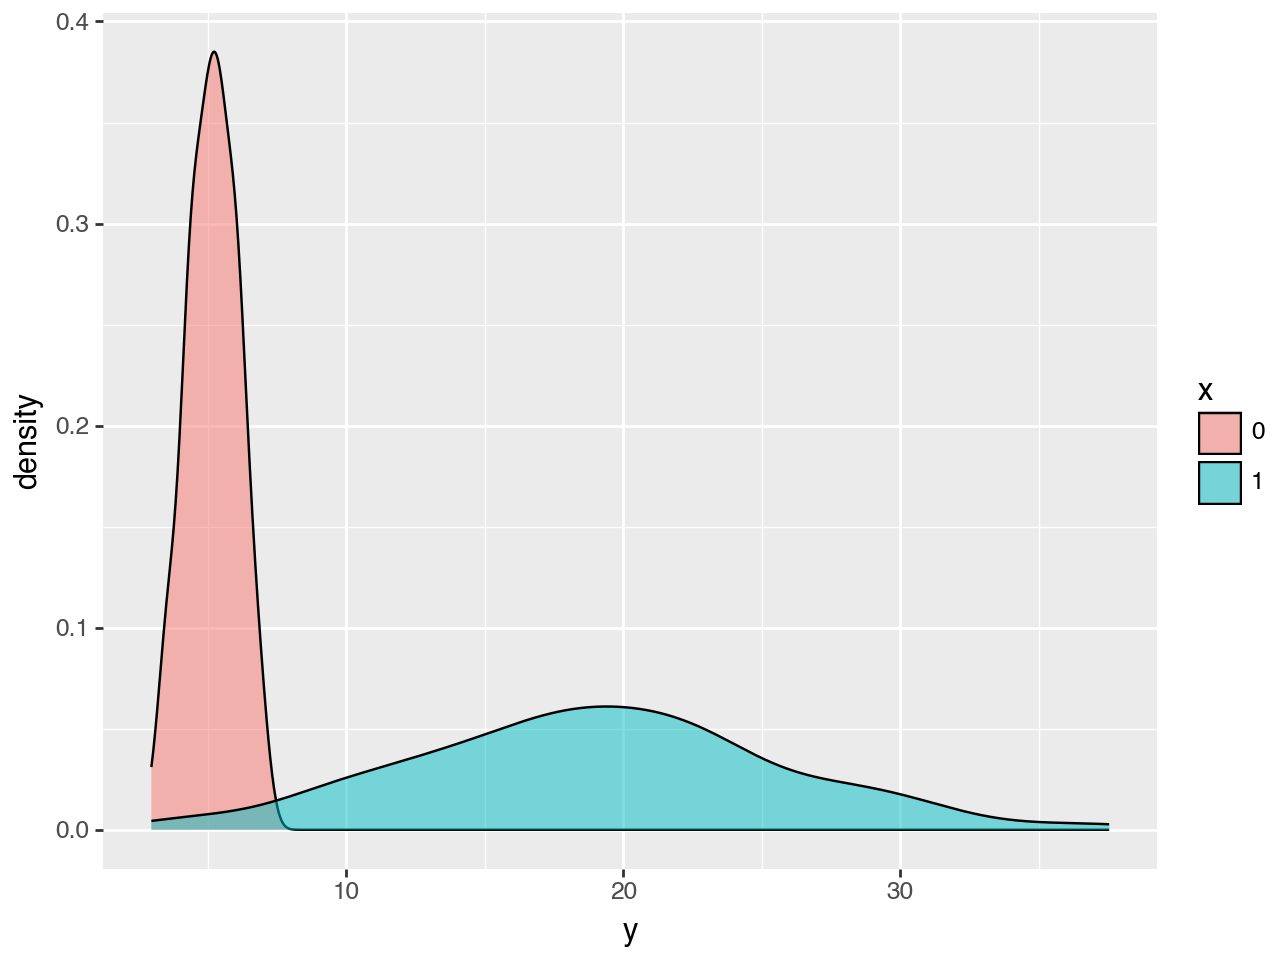

In [47]:
p9.ggplot(df) + p9.geom_density(p9.aes("y", fill="x"), alpha = 0.5)

## Set up a Liesel model

We will set up a model with diffuse Gaussian priors $N(0, 100^2)$ on the model parameters.

### Location model

liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.


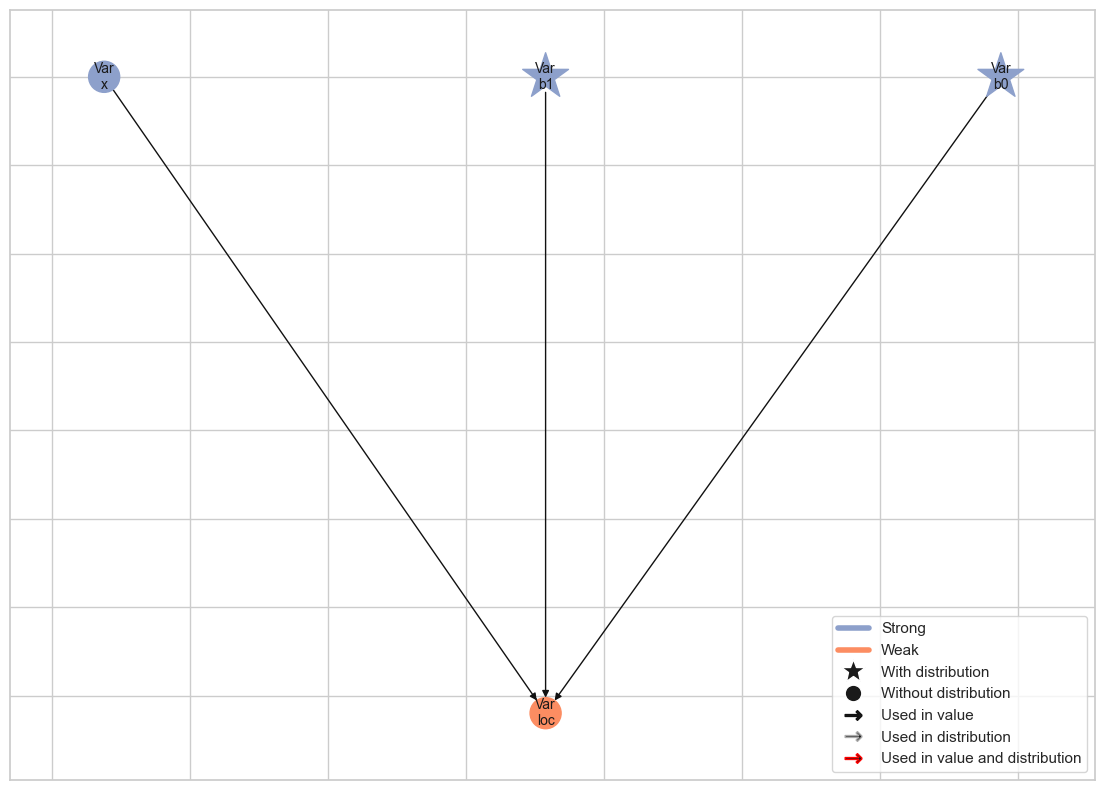

In [48]:
b0_var = lsl.Var.new_param( # initialize a parameter variable
    value=0.0, # initial value
    distribution=lsl.Dist(tfd.Normal, loc=0.0, scale=100.0), # lsl.Dist wraps tfd distribution classes.
    inference=None,  # here, we can define how this parameter should be estimated. We don't do this right now.
    name="b0"
)

b1_var = lsl.Var.new_param(
    value=0.0, # initial value
    distribution=lsl.Dist(tfd.Normal, loc=0.0, scale=100.0), # lsl.Dist wraps tfd distribution classes.
    inference=None,
    name="b1"
)

x_var = lsl.Var.new_obs( # initialize an observed variable
    value=x,
    name="x"
)


def compute_loc(b0, b1, x):
    return b0 + b1*x

loc = lsl.Var.new_calc(   # this is a calculated variable
    function=compute_loc, # we pass the function that should be used to calculate the value
    b0=b0_var,            # The arguments to the function are our liesel variables
    b1=b1_var,
    x=x_var,
    name="loc"
)

loc.plot_vars()

### Scale model

liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.


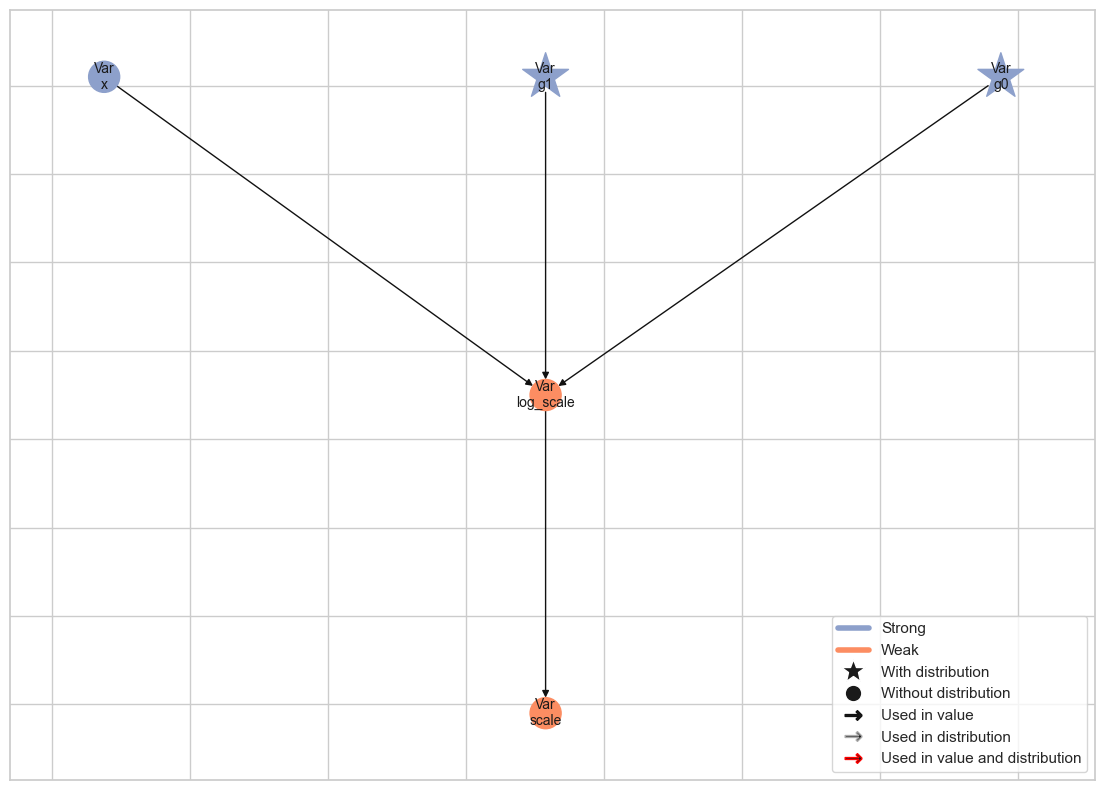

In [49]:
g0_var = lsl.Var.new_param( # initialize a parameter variable
    value=0.0, # initial value
    distribution=lsl.Dist(tfd.Normal, loc=0.0, scale=100.0), # lsl.Dist wraps tfd distribution classes.
    inference=None,  # here, we can define how this parameter should be estimated. We don't do this right now.
    name="g0"
)

g1_var = lsl.Var.new_param(
    value=0.0, # initial value
    distribution=lsl.Dist(tfd.Normal, loc=0.0, scale=100.0), # lsl.Dist wraps tfd distribution classes.
    inference=None,
    name="g1"
)


def compute_log_scale(g0, g1, x):
    return g0 + g1*x

log_scale = lsl.Var.new_calc(   # this is a calculated variable
    function=compute_log_scale, # we pass the function that should be used to calculate the value
    g0=g0_var,            # The arguments to the function are our liesel variables
    g1=g1_var,
    x=x_var,
    name="log_scale"
)

scale = lsl.Var.new_calc(jnp.exp, log_scale, name="scale")

scale.plot_vars()

### Observation model

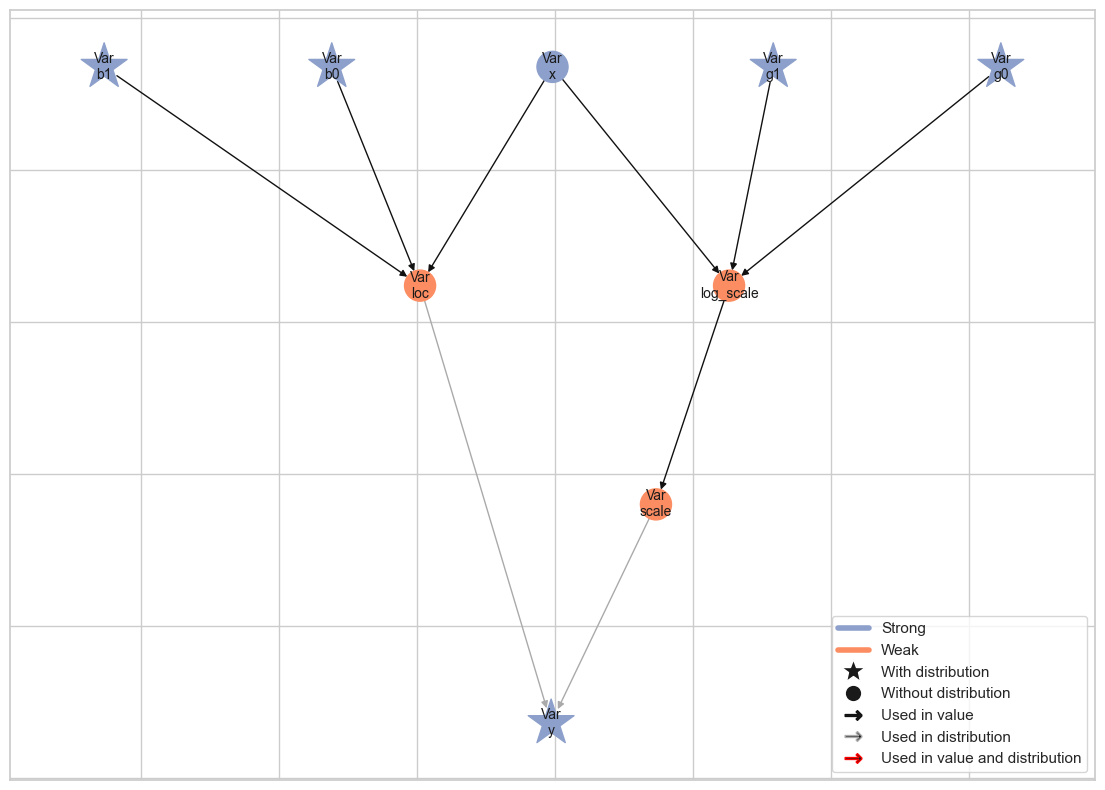

In [50]:
y_var = lsl.Var.new_obs(
    value=y,
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y"
)

model = lsl.Model([y_var])
model.plot_vars()

## MCMC Sampling

### Define variable-specific inference specifications

These specifications could have been set further above in the `Var.new_param(..., inference=None)` arguments. We moved it down here only to keep the presentation further up more clean.

In [51]:
b1_var.inference = gs.MCMCSpec( # as of Liesel v0.4, MCMC is the only out-of-the-box estimation algorithm in Liesel. More may be added.
    gs.IWLSKernel,          # Choose one of the builtin kernel classes
    kernel_group="loc"      # with this argument, you can group parameters to be sampled in one block
)

b0_var.inference = gs.MCMCSpec(
    gs.IWLSKernel,
    kernel_group="loc"
)

# just for demonstration purposes, we use a different kernel (NUTS)
# for the parameters in the scale model part
# and don't block them together
g0_var.inference = gs.MCMCSpec(gs.NUTSKernel)
g1_var.inference = gs.MCMCSpec(gs.NUTSKernel)

### Set up MCMC algorithm

In [52]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1,        # seed for random number generation in MCMC sampling
    num_chains=4   # number of parallel chains to run
)

# set duration of warmup and posterior sampling
eb.set_duration(
    warmup_duration=1000,
    posterior_duration=1000,
    term_duration=500,
    thinning_posterior=1
)

engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'g1', 'g0', 'b1', 'b0'. The initial values for these keys won't be jittered


liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


### Run MCMC algorithm

In [53]:
engine.sample_all_epochs()
results = engine.get_results()
samples = results.get_posterior_samples()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 5, 5, 3, 4 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 3, 2, 2, 3 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 758.60chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 2, 2, 0 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1146.61chunk/s]
liesel.goo

### Summary & Diagnostics

Liesel.goose offers posterior summaries and several diagnostics out of the box.
We can also easily plot trace plots, autocorrelation plots, and pairwise scatterplots.

In [54]:
gs.Summary(results)

Parameter summary:

                    kernel       mean        sd     q_0.05      q_0.5  \
parameter index                                                         
b0        ()     kernel_02   5.173970  0.077309   5.044858   5.173801   
b1        ()     kernel_02  13.896102  0.543047  12.995914  13.886247   
g0        ()     kernel_01  -0.088877  0.057979  -0.185167  -0.089705   
g1        ()     kernel_00   1.974571  0.082512   1.838237   1.971512   

                    q_0.95  sample_size     ess_bulk     ess_tail      rhat  
parameter index                                                              
b0        ()      5.299882         4000  1511.327371  2424.359713  1.001333  
b1        ()     14.790103         4000  1792.931244  2281.853664  1.002343  
g0        ()      0.007002         4000   609.678592  1165.403267  1.002829  
g1        ()      2.114562         4000   657.055245  1092.745101  1.001237  

Error summary:

                                                    count relative
kernel    error_code error_msg            phase                   
kernel_00 1          divergent transition warmup       58   0.0145
                                          posterior     0      0.0
kernel_01 1          divergent transition warmup       46   0.0115
                                          posterior     0      0.0

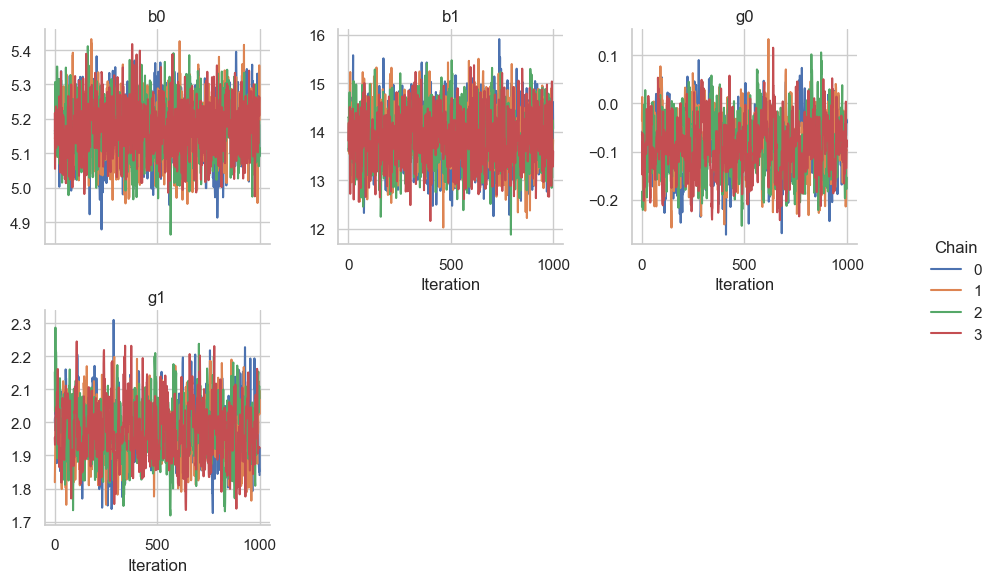

In [55]:
gs.plot_trace(results)

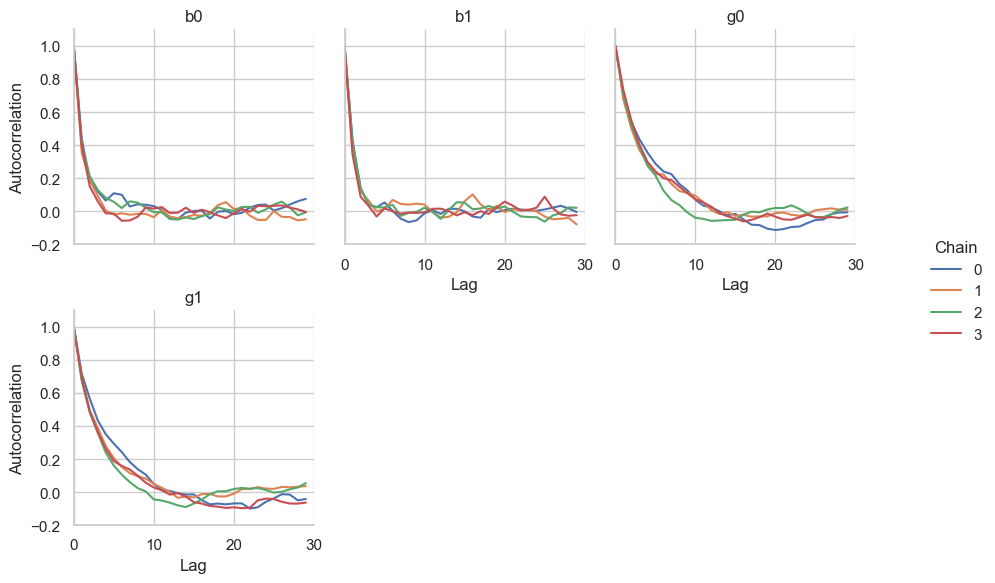

In [56]:
gs.plot_cor(results)

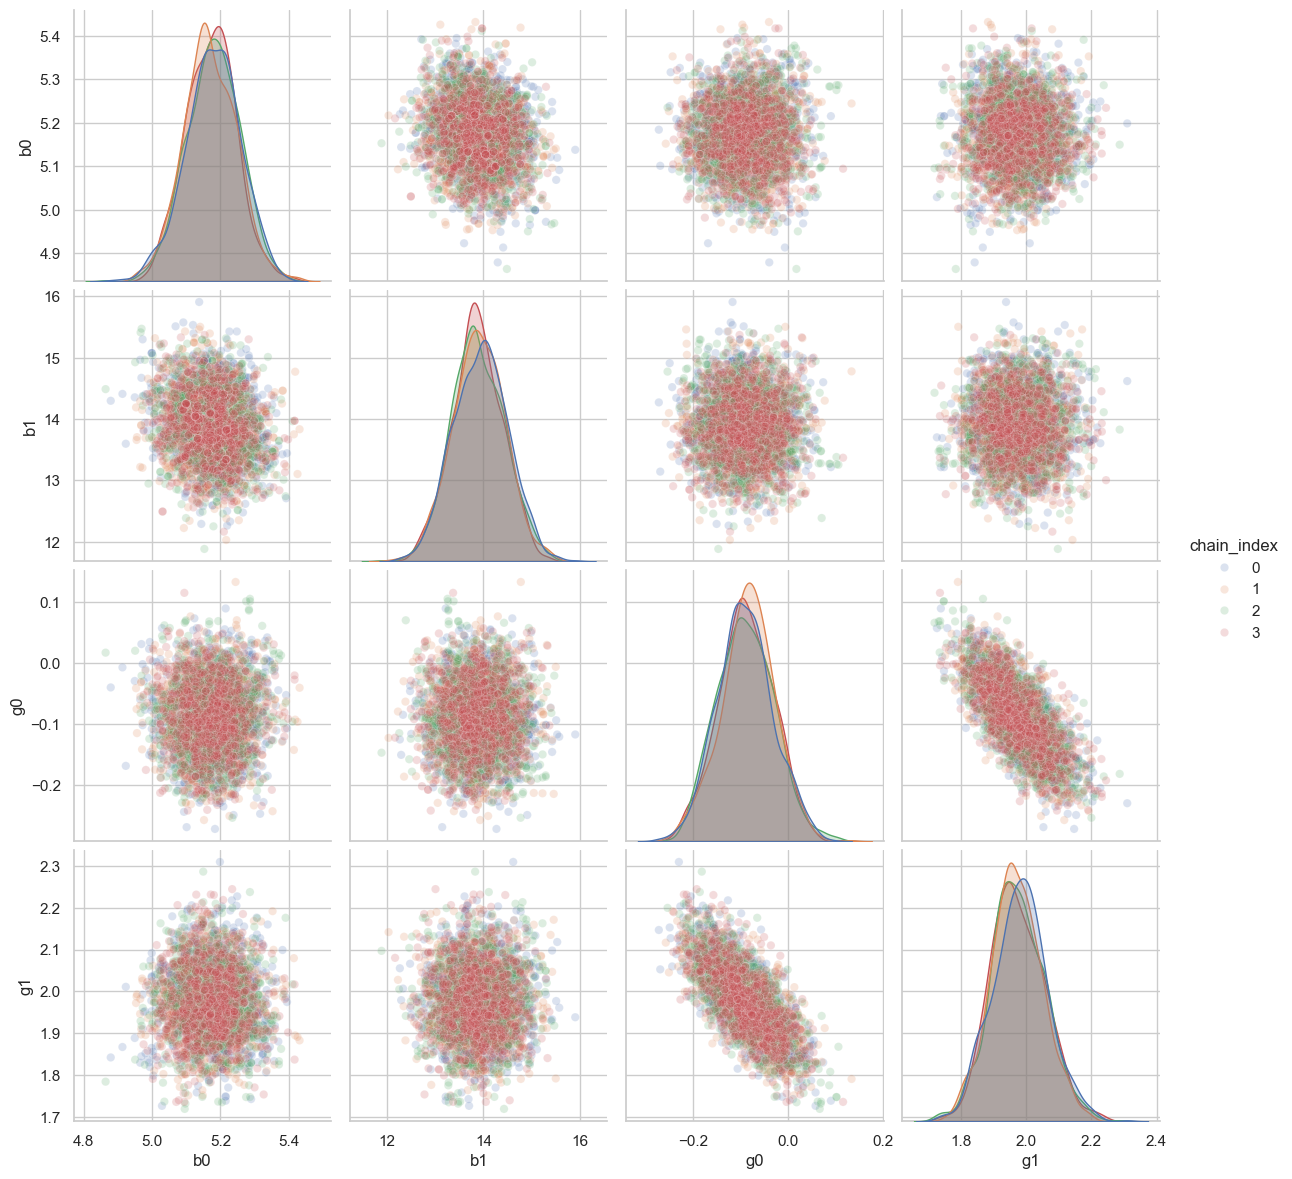

In [57]:
gs.plot_pairs(results)

## Predictions

We can use the posterior samples to compute predictions for new data using the model graph.

In [58]:
predictions = model.predict(
    samples=samples,          # pass the posterior samples dictionary here
    predict=["loc", "scale"], # names of the model variables that you want to predict values for
    newdata={"x": jnp.array([0.0, 1.0])} # new values of observed variables at which to predict
)

print(list(predictions))
print(predictions["loc"].shape) # has shape (nchains, nsamples, ...)

['loc', 'scale']
(4, 1000, 2)


In [59]:
nchains, nsamples, ngrid = predictions["loc"].shape
predicted_loc = jnp.reshape(predictions["loc"], (nchains*nsamples, ngrid))
predicted_scale = jnp.reshape(predictions["scale"], (nchains*nsamples, ngrid))

In [60]:
predicted_df = pd.DataFrame(predicted_loc.T)
predicted_df["x"] = pd.Categorical(np.array([0.0, 1.0]))
predicted_df = predicted_df.melt(id_vars=["x"], var_name="sample", value_name="loc")

pred_scale_df = pd.DataFrame(predicted_scale.T)
pred_scale_df["x"] = pd.Categorical(np.array([0.0, 1.0]))

predicted_df["scale"] = pred_scale_df.melt(id_vars=["x"])["value"]
predicted_df

,x,sample,loc,scale
0,0.0,0,5.165122,0.943320
1,1.0,0,18.808764,6.993324
2,0.0,1,5.165122,0.935564
3,1.0,1,18.808764,7.008383
4,0.0,2,5.165122,0.877920
...,...,...,...,...
7995,1.0,3997,18.493868,6.152326
7996,0.0,3998,5.209458,0.927050
7997,1.0,3998,18.493868,6.341356
7998,0.0,3999,5.262288,0.914193


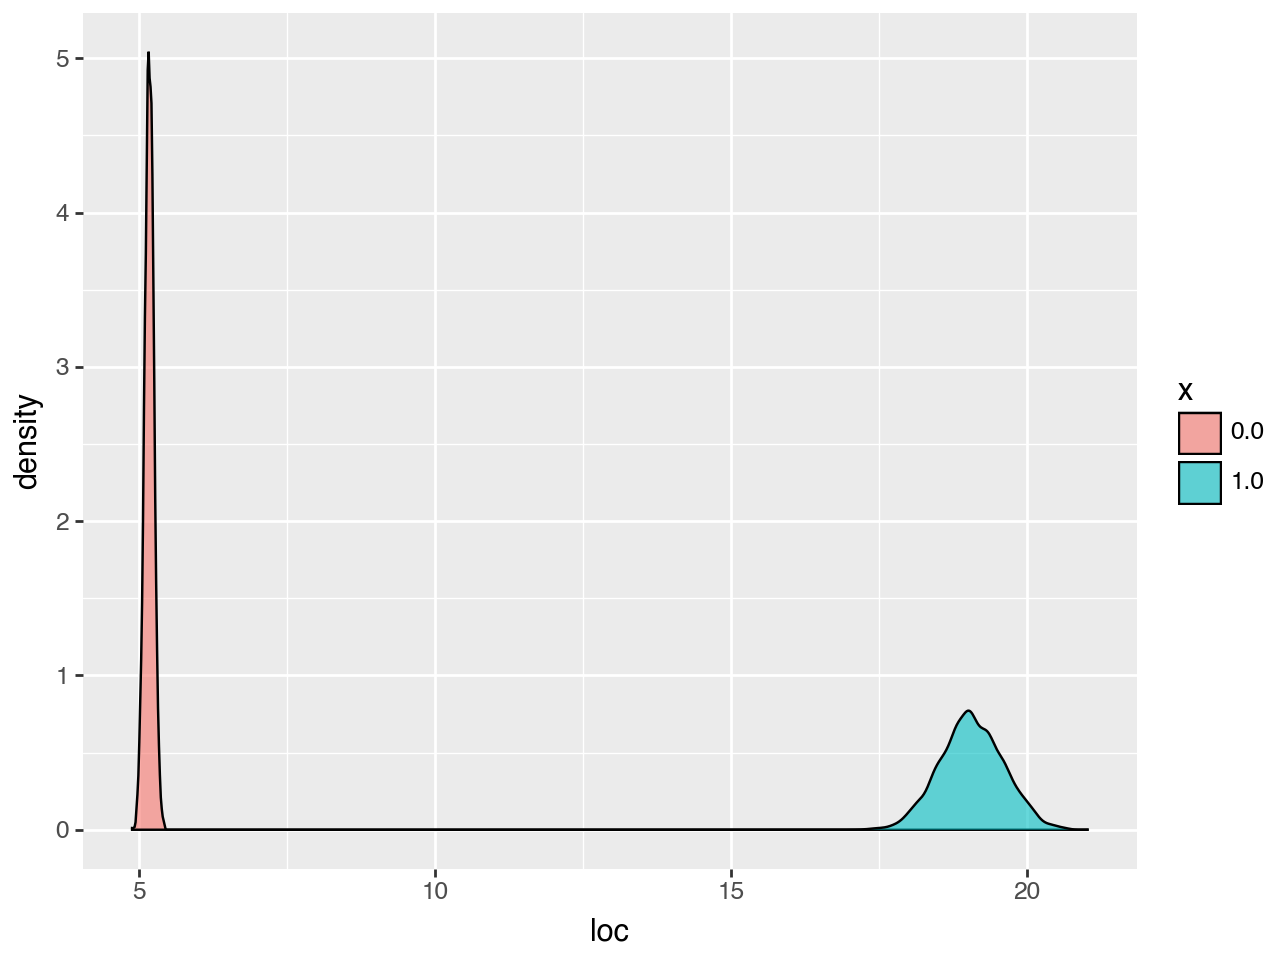

In [61]:
(
    p9.ggplot(predicted_df)
    + p9.geom_density(p9.aes("loc", fill="x"), alpha = 0.6)
)

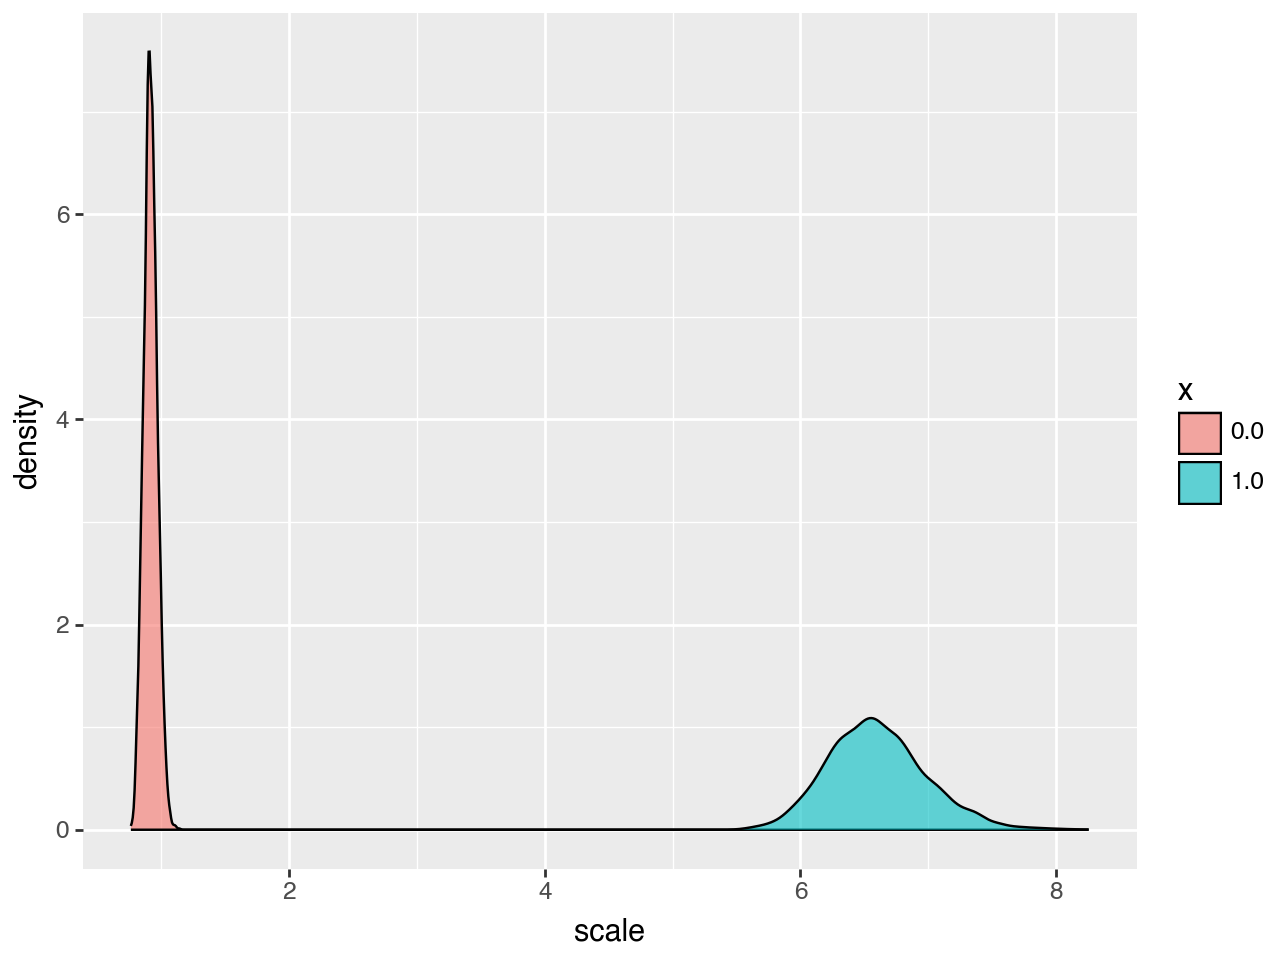

In [62]:
(
    p9.ggplot(predicted_df)
    + p9.geom_density(p9.aes("scale", fill="x"), alpha = 0.6)
)

## Posterior predictive samples

In [63]:
k, subkey = split(k)
ppred_samples = model.sample(
    shape=(1,),  # here, we draw only one preditive sample for each posterior sample
    seed=subkey, 
    posterior_samples=samples, 
)

print(list(ppred_samples))
print(ppred_samples["y"].shape)

['y']
(1, 4, 1000, 300)


In [64]:
npp, nchains, nsamples, nobs = ppred_samples["y"].shape

ppred_y = jnp.reshape(ppred_samples["y"], (npp*nchains*nsamples, nobs))
ppred_df = pd.DataFrame(ppred_y.T)
ppred_df["x"] = pd.Categorical(np.asarray(x))
ppred_df = ppred_df.melt(id_vars=["x"], var_name="sample", value_name="y")

Our posterior predictive samples look reasonable.

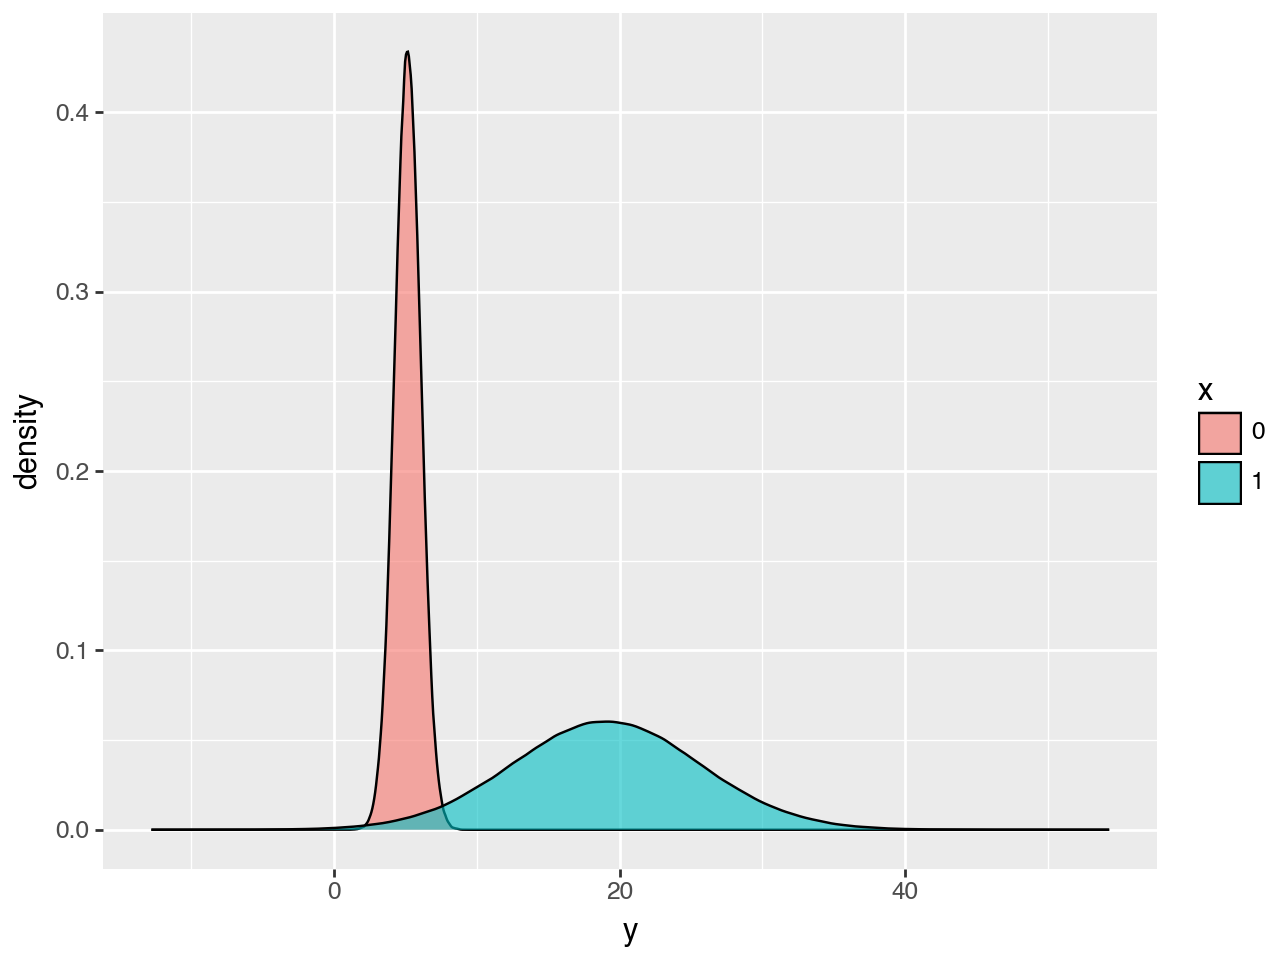

In [65]:
(
    p9.ggplot(ppred_df)
    + p9.geom_density(p9.aes("y", fill="x"), alpha = 0.6)
)

## Prior Predictive Simulations

In Bayesian models, we can draw pseudo-random samples from the priors of all parameters, and feed these samples into the observation model to draw "predictive" samples from the prior model. This is way to gain information about how restrictive or non-restrictive our prior is.

In [66]:
k, subkey = split(k)
prior_samples = model.sample(shape=(100,), seed=subkey)

# we get a dictionary of samples for all variables with distributions in the model
list(prior_samples) 

['b0', 'b1', 'g0', 'g1', 'y']

In [67]:
# since we have (nobs,) fixed x observations, our samples for y have shape (100, nobs),
# meaning that for *each* observation of x, we got 100 new y samples.
prior_samples["y"].shape

(100, 300)

In [68]:
prior_pred_df = pd.DataFrame(prior_samples["y"].T)
prior_pred_df["x"] = pd.Categorical(np.asarray(x))
prior_pred_df = prior_pred_df.melt(id_vars=["x"])

In [69]:
# we have a lot of infinite values here
# these are consequences of our highly dispersed priors
# when some values get too large or too small, they become "numerically infinite"
print(np.isinf(prior_pred_df["value"]).sum())

# we remove the infinite values from further analysis
prior_pred_df = prior_pred_df.loc[~np.isinf(prior_pred_df["value"])]

6036


In [70]:
# the minimum and maximum values here are absolutely unrealtistic
print("min", prior_pred_df["value"].min())
print("max", prior_pred_df["value"].max())

min -3.266491e+38
max 3.1738322e+38


In [71]:
# to sensibly plot these values, we need to restrict them
# here, I remove all values smaller than -1000.0 and greater than 1000.0
prior_pred_df = prior_pred_df.loc[prior_pred_df["value"] < 1e3]
prior_pred_df = prior_pred_df.loc[prior_pred_df["value"] > -1e3]

/Users/johannesbrachem/Documents/git/statistics-retreat-2025/.venv/lib/python3.13/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 193'. Pick better value with 'binwidth'.


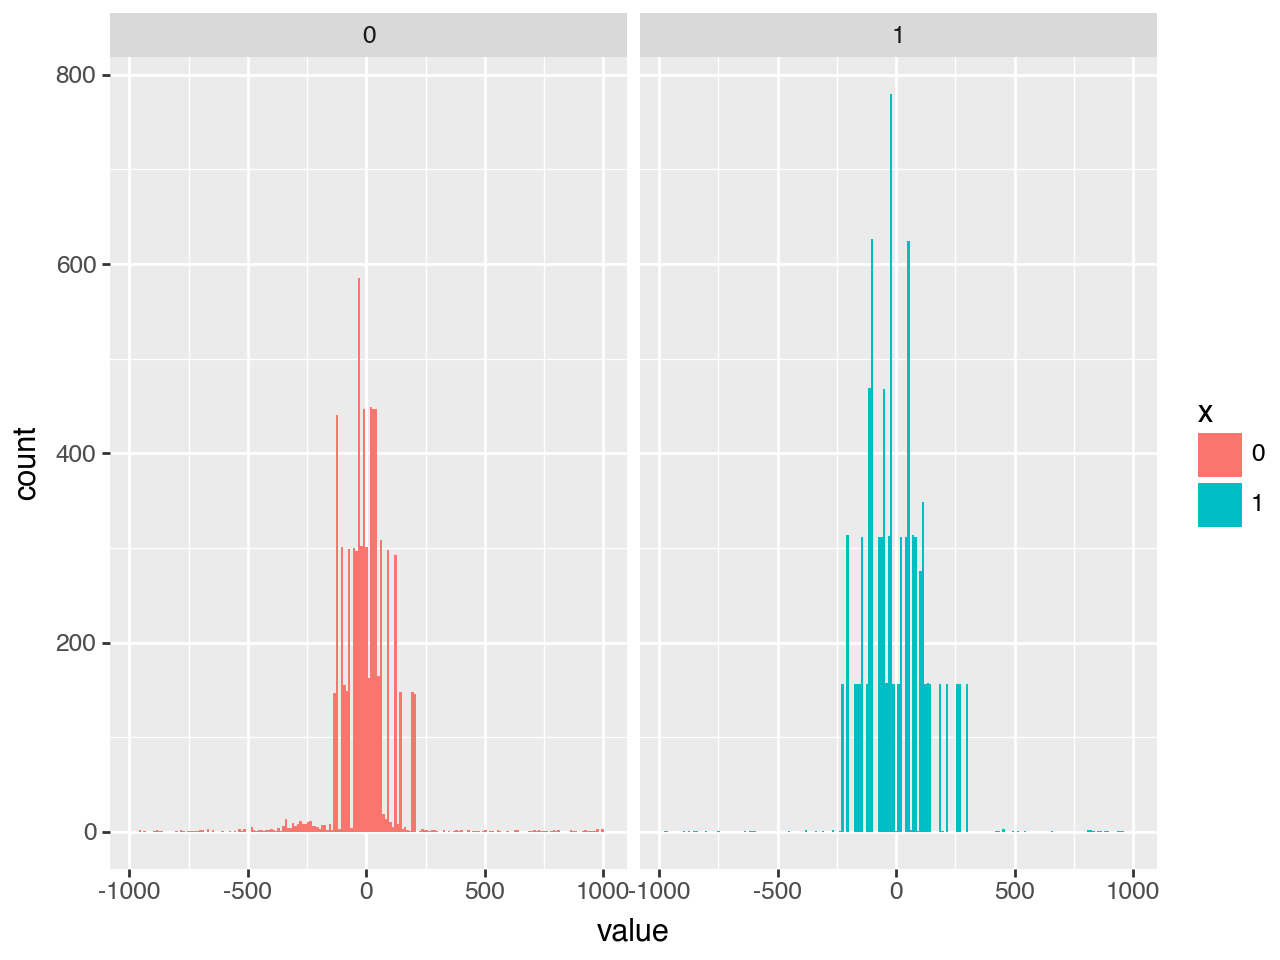

In [72]:
# The histograms suggest that our model and its priors allow for 
# impossible negative weights and unrealistically large positive weights of
# more than 250 kg. Inidivual samples are even up to 1000 kg or -1000 kg.
p9.ggplot(prior_pred_df) + p9.geom_histogram(p9.aes("value", fill="x")) + p9.facet_wrap("~x")

In this case, the prior predictive simulations tell us that our model incorporates much less
reliable prior information than we have. We could make the model much more realistic by:

1. Ensuring that the weight is always positive.
2. Ensuring that the prior does not assign notable probability to unrealtistic weights like 1000 kg.